In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from joblib import dump, load

from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train['train_test'] = 'train'
test['train_test'] = 'test'

data = pd.concat([train, test])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [3]:
data.shape

(258210, 16)

In [4]:
test.shape

(83210, 16)

In [5]:
data.head()

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,NaN,NaN,NaN,train,PORTUGUESE RED,J. Portugal Ramos
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier
2,France,"This is powerful and concentrated, with the hi...",NaN,32440,NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Figeac
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,124405,NaN,89.869797,34.0,California,Santa Barbara County,Central Coast,NaN,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,train,PETITE SIRAH,Jaffurs
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,33649,NaN,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,train,ROSé,Syncline


In [6]:
data['province'].mode()

0    California
dtype: object

In [7]:
data.variety.fillna(value='PINOT NOIR', inplace=True)

In [8]:
data.province.fillna(value='California', inplace=True)

In [9]:
#data = data[pd.notnull(data['variety'])]
#data = data[pd.notnull(data['province'])]

In [10]:
data.taster_name.fillna(value='Roger Voss', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 16 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    91559 non-null object
title                    120975 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 33.5+ MB


In [11]:
data.title.fillna(value='Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 16 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    91559 non-null object
title                    258210 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 33.5+ MB


In [12]:
data['province'] = pd.Categorical(data['province'])
proDummies = pd.get_dummies(data['province'], prefix = 'prov')

data['country'] = pd.Categorical(data['country'])
countDummies = pd.get_dummies(data['country'], prefix = 'country')

data['variety'] = pd.Categorical(data['variety'])
varDummies = pd.get_dummies(data['variety'], prefix = 'variety')

data['taster_name'] = pd.Categorical(data['taster_name'])
tastDummies = pd.get_dummies(data['taster_name'], prefix = 'taster')

#data['title'] = pd.Categorical(data['title'])
#titleDummies = pd.get_dummies(data['title'], prefix = 'title')

In [13]:
def getQuality(points):
    if(points <= 85):
        return 'bad'
    elif(points<=90 ):
        return 'ok'
    elif(points<=95):
        return 'good'
    elif(points<=102):
        return 'great'
    else:
        return 'If this gets hit, we did something wrong!'

In [14]:
data['quality'] = data['points'].apply(getQuality)
cleanup_nums = {"quality":     {"ok": 2, "good": 3, "bad": 1, "great": 4},
                "priceRange": {"1-30": 1, "31-50": 2, "51-100": 3, "Above 100": 4}}

data.replace(cleanup_nums, inplace=True)

In [15]:
data.head()

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery,quality
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,PORTUGUESE RED,J. Portugal Ramos,2
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier,2
2,France,"This is powerful and concentrated, with the hi...",NaN,32440,NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,BORDEAUX-STYLE RED BLEND,Château Figeac,3
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,124405,NaN,89.869797,34.0,California,Santa Barbara County,Central Coast,Roger Voss,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,train,PETITE SIRAH,Jaffurs,2
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,33649,NaN,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,train,ROSé,Syncline,2


In [16]:
def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [17]:
data["description"] = data["description"].str.replace('\d+', '')
data["description"] = data.description.apply(func=remove_punctuation)
data["description"] = data.description.apply(func=make_lower_case)

In [18]:
data["variety"] = data["variety"].str.replace('\d+', '')
data["variety"] = data.variety.apply(func=remove_punctuation)
data["variety"] = data.variety.apply(func=make_lower_case)

In [19]:
data["title"] = data["title"].str.replace('\d+', '')
data["title"] = data.title.apply(func=remove_punctuation)
data["title"] = data.title.apply(func=make_lower_case)

In [20]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=10)

In [21]:
#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(data.description)
desc_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["description_" + s for s in collist]
desc_features.columns = collist
desc_features.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,description_10,description_11,description_12,description_13,description_14,description_15,description_16,description_17,description_18,description_19
0,0.115367,0.004640,0.114801,0.051542,0.006793,-0.031496,-0.024005,0.041638,0.027456,-0.011197,0.018775,-0.025218,0.007464,-0.033202,-0.003258,0.037280,0.005295,-0.019955,-0.009657,-0.033270
1,0.119707,0.024873,0.072269,0.021840,-0.011869,-0.064065,0.001466,0.028788,0.014894,0.003608,-0.026451,0.005754,-0.033627,0.032967,-0.061463,0.035623,0.007427,0.021214,-0.001469,-0.008171
2,0.129262,0.101735,0.087877,0.004010,0.131330,-0.034264,-0.013705,0.004330,0.070871,-0.005494,0.041285,-0.022445,-0.053891,-0.013894,-0.044062,0.074523,0.043519,0.018489,-0.014965,0.015549
3,0.103500,0.062310,0.012503,-0.064518,-0.019670,-0.063391,-0.014358,-0.007634,0.047376,0.040620,0.001101,-0.020603,-0.026612,0.034218,-0.001922,-0.027749,-0.017213,-0.080654,-0.000797,-0.010556
4,0.096223,-0.056868,-0.015419,-0.013099,0.023276,0.028224,0.004739,0.015456,-0.026170,0.034948,-0.043395,-0.027959,-0.012161,0.006658,-0.000458,0.015651,-0.020596,0.037515,-0.007767,-0.011396


In [22]:
tfidf_matrix = tf.fit_transform(data.variety)
var_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["variety_" + s for s in collist]
var_features.columns = collist
var_features.head()

,variety_0,variety_1,variety_2,variety_3,variety_4,variety_5,variety_6,variety_7,variety_8,variety_9,variety_10,variety_11,variety_12,variety_13,variety_14,variety_15,variety_16,variety_17,variety_18,variety_19
0,3.170330e-06,1.301193e-05,4.913885e-02,2.476377e-01,-2.086081e-05,4.367687e-04,5.558884e-05,-2.374665e-06,-2.942376e-05,-0.182168,-0.001047,0.000966,-5.500712e-05,-0.077361,-0.062966,0.864874,7.948663e-04,0.334156,0.003037,-0.000621
1,1.044208e-05,4.052582e-05,1.488023e-01,7.480533e-01,-4.508678e-05,8.007510e-04,9.949254e-05,-1.131862e-05,-4.672484e-06,0.613722,-0.000767,0.000090,-7.540394e-05,-0.148758,0.027632,0.019447,1.026984e-03,0.052548,0.001962,0.006414
2,1.044209e-05,4.052581e-05,1.488023e-01,7.480533e-01,-4.508678e-05,8.007510e-04,9.949254e-05,-1.131862e-05,-4.672484e-06,0.613722,-0.000767,0.000090,-7.540394e-05,-0.148758,0.027632,0.019447,1.026984e-03,0.052548,0.001962,0.006414
3,5.421560e-07,-2.080221e-08,1.239084e-06,-7.050737e-07,5.091452e-05,-5.167684e-05,7.213312e-04,-3.969507e-05,-7.916600e-05,-0.000019,-0.000812,0.000004,-4.545212e-04,0.000076,-0.001203,-0.000788,5.744077e-03,-0.002416,0.015284,0.017756
4,-1.234976e-10,1.495346e-10,8.341445e-07,4.232235e-06,2.028222e-08,7.988626e-08,2.833158e-08,9.132181e-09,3.220837e-07,-0.000332,0.000013,0.999998,7.758698e-07,-0.000970,0.000167,-0.001154,8.003995e-07,-0.000342,0.000004,0.000004


In [23]:
prov_features = pd.DataFrame(svd.fit_transform(proDummies.values))
collist = map(str, range(0, 10))
collist = ["province_" + s for s in collist]
prov_features.columns = collist
prov_features.head()

,province_0,province_1,province_2,province_3,province_4,province_5,province_6,province_7,province_8,province_9,province_10,province_11,province_12,province_13,province_14,province_15,province_16,province_17,province_18,province_19
0,2.083727e-10,-1.192560e-06,8.937481e-06,-4.340303e-06,1.092370e-05,1.010577e-05,-1.029029e-04,4.968498e-05,-1.076440e-04,-2.528247e-04,-3.464193e-04,2.314199e-04,-4.650287e-04,5.270797e-03,-3.871523e-04,-2.946881e-03,1.172044e-02,-1.230303e-02,-1.681116e-02,1.532929e-02
1,1.497895e-14,-1.337569e-10,9.352537e-10,1.370770e-09,2.900885e-09,-8.903064e-09,1.000000e+00,-1.488077e-07,6.661216e-08,6.954048e-09,3.141768e-08,-5.304219e-08,-4.578617e-09,-1.576563e-07,4.881231e-08,9.479621e-08,1.090631e-07,8.479020e-08,2.198555e-07,-5.367256e-08
2,2.814776e-14,-1.438887e-10,8.889552e-10,1.370645e-09,2.900910e-09,-8.903147e-09,1.000000e+00,-1.488077e-07,6.661215e-08,6.954053e-09,3.141769e-08,-5.304219e-08,-4.578633e-09,-1.576563e-07,4.881232e-08,9.479622e-08,1.090631e-07,8.479021e-08,2.198555e-07,-5.367264e-08
3,1.000000e+00,-1.159038e-14,-1.312586e-13,2.000994e-13,-9.311238e-14,-4.613452e-13,1.649589e-13,-4.171858e-13,-5.032920e-14,2.664294e-15,-1.916228e-14,1.156322e-14,-6.017781e-14,-2.095755e-13,3.396847e-15,1.001830e-14,2.657045e-14,-4.617099e-14,-1.694294e-13,-3.700715e-13
4,1.171859e-14,1.000000e+00,2.599942e-13,2.320372e-12,-3.031972e-12,-1.814718e-12,2.130189e-11,2.612542e-12,5.177657e-11,2.972108e-11,3.327136e-13,2.152206e-11,8.517406e-11,-3.351135e-10,1.113547e-10,-6.257226e-11,2.034551e-10,-4.973269e-11,4.488236e-10,-1.463879e-10


In [24]:
#tfidf_matrix = tf.fit_transform(data.region_1)
#reg1_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
#collist = map(str, range(0, 10))
#collist = ["country_" + s for s in collist]
#reg1_features.columns = collist
#reg1_features.head()

In [25]:
#svd = TruncatedSVD(n_components=10)
country_features = pd.DataFrame(svd.fit_transform(countDummies.values))
collist = map(str, range(0, 10))
collist = ["country_" + s for s in collist]
country_features.columns = collist
country_features.head()

,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,5.516678e-15,-4.256875e-14,1.757118e-13,-3.032821e-13,2.289219e-14,1.343912e-13,1.000000e+00,-3.264163e-13,3.345912e-13,2.523423e-13
1,5.976398e-15,-6.837005e-11,1.000000e+00,5.572619e-15,-1.520452e-15,-8.424279e-16,1.606422e-15,-4.188622e-15,3.599350e-14,-1.331097e-13
2,1.013479e-15,7.729164e-14,1.000000e+00,-5.286311e-12,7.985281e-15,3.584899e-15,-7.434954e-15,-5.480050e-14,-2.987197e-14,1.510278e-13
3,1.000000e+00,-1.893373e-15,1.561904e-15,1.427854e-13,3.398976e-13,1.033041e-12,-4.512930e-13,-5.809541e-14,1.726874e-14,-1.503880e-15
4,1.000000e+00,-8.341652e-14,4.368500e-14,-7.861503e-13,-1.978424e-11,6.054405e-11,-9.568801e-12,9.723300e-15,2.019009e-14,-1.968622e-15


In [26]:
dd = pd.concat([desc_features, var_features, prov_features, country_features], axis=1)
dd.shape

(258210, 70)

In [27]:
dd.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,0.115367,0.004640,0.114801,0.051542,0.006793,-0.031496,-0.024005,0.041638,0.027456,-0.011197,...,5.516678e-15,-4.256875e-14,1.757118e-13,-3.032821e-13,2.289219e-14,1.343912e-13,1.000000e+00,-3.264163e-13,3.345912e-13,2.523423e-13
1,0.119707,0.024873,0.072269,0.021840,-0.011869,-0.064065,0.001466,0.028788,0.014894,0.003608,...,5.976398e-15,-6.837005e-11,1.000000e+00,5.572619e-15,-1.520452e-15,-8.424279e-16,1.606422e-15,-4.188622e-15,3.599350e-14,-1.331097e-13
2,0.129262,0.101735,0.087877,0.004010,0.131330,-0.034264,-0.013705,0.004330,0.070871,-0.005494,...,1.013479e-15,7.729164e-14,1.000000e+00,-5.286311e-12,7.985281e-15,3.584899e-15,-7.434954e-15,-5.480050e-14,-2.987197e-14,1.510278e-13
3,0.103500,0.062310,0.012503,-0.064518,-0.019670,-0.063391,-0.014358,-0.007634,0.047376,0.040620,...,1.000000e+00,-1.893373e-15,1.561904e-15,1.427854e-13,3.398976e-13,1.033041e-12,-4.512930e-13,-5.809541e-14,1.726874e-14,-1.503880e-15
4,0.096223,-0.056868,-0.015419,-0.013099,0.023276,0.028224,0.004739,0.015456,-0.026170,0.034948,...,1.000000e+00,-8.341652e-14,4.368500e-14,-7.861503e-13,-1.978424e-11,6.054405e-11,-9.568801e-12,9.723300e-15,2.019009e-14,-1.968622e-15


In [28]:
dd.shape

(258210, 70)

In [29]:
#data.drop('index', axis=1, inplace=True)

In [30]:
dd['train_test'] = data.train_test.values

In [31]:
dd['id'] = data.id.values

In [32]:
dd['quality'] = data.quality.values

In [33]:
dd['points'] = data.points.values

In [34]:
dd['price'] = data.price.values

In [35]:
#['id', 'points', 'quality', 'price']
final_data = dd.copy()
final_data.shape

(258210, 75)

In [37]:
final_data['sum_desc'] = final_data[['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9']].sum(axis=1)

In [38]:
final_data['sum_var'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)

In [39]:
final_data['sum_prov'] = final_data[['province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9']].sum(axis=1)

In [40]:
final_data['sum_country'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)

In [ ]:
final_data['description_0_x2'] = final_data['description_0'].multiply(4)
final_data['description_1_x2'] = final_data['description_1'].multiply()
final_data['description_2_x2'] = final_data['description_2'].multiply(2)
final_data['description_3_x2'] = final_data['description_3'].multiply(2)

In [41]:
final_data.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,country_9,train_test,id,quality,points,price,sum_desc,sum_var,sum_prov,sum_country
0,0.115367,0.004640,0.114801,0.051542,0.006793,-0.031496,-0.024005,0.041638,0.027456,-0.011197,...,2.523423e-13,train,32027,2,88.870874,20.0,0.295538,0.115064,-0.000389,0.115064
1,0.119707,0.024873,0.072269,0.021840,-0.011869,-0.064065,0.001466,0.028788,0.014894,0.003608,...,-1.331097e-13,train,71079,2,88.041695,28.0,0.211510,1.511467,1.000000,1.511467
2,0.129262,0.101735,0.087877,0.004010,0.131330,-0.034264,-0.013705,0.004330,0.070871,-0.005494,...,1.510278e-13,train,32440,3,94.085021,130.0,0.475953,1.511467,1.000000,1.511467
3,0.103500,0.062310,0.012503,-0.064518,-0.019670,-0.063391,-0.014358,-0.007634,0.047376,0.040620,...,-1.503880e-15,train,124405,2,89.869797,34.0,0.096738,0.000584,1.000000,0.000584
4,0.096223,-0.056868,-0.015419,-0.013099,0.023276,0.028224,0.004739,0.015456,-0.026170,0.034948,...,-1.968622e-15,train,33649,2,89.017651,24.0,0.091310,-0.000326,1.000000,-0.000326


In [42]:
train_data = final_data[final_data['train_test'] == 'train']
test_data = final_data[final_data['train_test'] == 'test']

In [93]:
#print(final_data.columns.tolist())

In [73]:
cols = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'description_10', 'description_11', 'description_12', 'description_13', 'description_14', 'description_15', 'description_16', 'description_17', 'description_18', 'description_19', 'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9', 'variety_10', 'variety_11', 'variety_12', 'variety_13', 'variety_14', 'variety_15', 'variety_16', 'variety_17', 'variety_18', 'variety_19', 'province_0', 'province_1', 'province_2', 'province_3', 'province_4', 'province_5', 'province_6', 'province_7', 'province_8', 'province_9', 'province_10', 'province_11', 'province_12', 'province_13', 'province_14', 'province_15', 'province_16', 'province_17', 'province_18', 'province_19', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7', 'country_8', 'country_9', 'points']

In [74]:
X = train_data[cols]
y = train_data["price"]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [76]:
print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

(52500, 71) (52500,) (122500, 71) (122500,)


In [77]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [78]:
#Set xgboost parameters
param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
param['nthread'] = 4
param['eval_metric'] = 'mae'
param['objective'] = 'reg:linear'
param['silent'] = 1
evallist = [(dtrain, 'train')]
num_round = 10

#Train model
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	train-mae:15.328
Will train until train-mae hasn't improved in 10 rounds.
[1]	train-mae:14.7451
[2]	train-mae:14.5284
[3]	train-mae:14.3726
[4]	train-mae:14.1675
[5]	train-mae:14.1313
[6]	train-mae:14.0678
[7]	train-mae:13.9748
[8]	train-mae:13.73
[9]	train-mae:13.6788


In [79]:
pred = pd.DataFrame(y_test.copy())
pred["prediction"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [80]:
rmse = np.round(np.sqrt(mean_squared_error(y_true=pred["price"], y_pred=pred["prediction"])), 2)
print ("Mean Squared Error: {} ".format(rmse))

Mean Squared Error: 29.24 


In [81]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [82]:
lm = Ridge()

lm.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [83]:
print(lm.intercept_)

-402.95336201599787


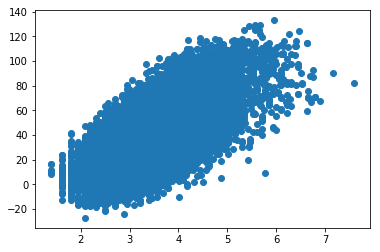

In [84]:
predictions = lm.predict(X_test)
plt.scatter(np.log(y_test),predictions)

In [85]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE: 31.07531101444151


In [86]:
rf = RandomForestRegressor()

In [87]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [88]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [89]:
predicts = rf.predict(X_test)

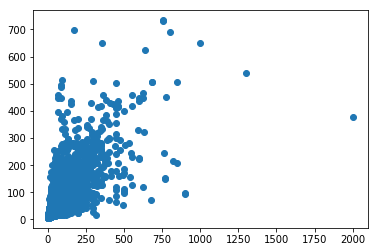

In [90]:
plt.scatter(y_test, predicts)

In [91]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predicts)))

RMSE: 23.25241351610214


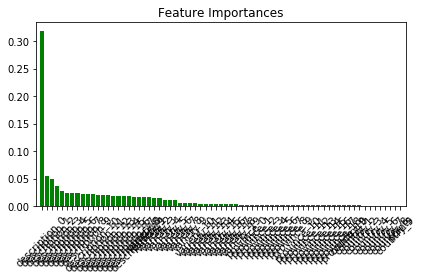

In [92]:
importances = rf.feature_importances_
features_label = X.columns
indices = np. argsort(importances)[::-1]
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], color="green", align="center")
plt.xticks(range(X.shape[1]),features_label, rotation=45)
plt.xlim([-1, X.shape[1]])
#plt.figure(figsize=(6,10))
plt.tight_layout()
plt.show()

In [ ]:
#print(test_data.columns.tolist())

In [ ]:
X_test_t = test_data[cols]

In [ ]:
test_data['price'] = rf.predict(X_test_t)
test_data['price'].head()

In [ ]:
test_data[['id', 'price']].to_csv('bma_price_predicted.csv', index=False)

In [ ]:
#pd.DataFrame(test_data_sss).to_csv('random_f.csv')

In [ ]:
import pickle

In [ ]:
#pickle.dump(rf,open('rf_model.sav','wb'))